In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/jp_program.csv', encoding='utf-8')

In [8]:
df.head()

,NO,방송사,제목,방영일,요일,회차,시청률,종합 순위,장르,장르별 순위,방송시작시간,방송종료시간,방송시간,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1,채널A,성적을 부탁해 티처스2,2024.9.1,일,24,1.339%,14.0,예능,6.0,19:50,21:00,1:10,NaN,NaN,NaN
1,2,채널A,성적을 부탁해 티처스2,2024.8.25,일,23,1.048%,26.0,예능,10.0,19:50,21:00,1:10,NaN,NaN,NaN
2,3,채널A,성적을 부탁해 티처스2,2024.8.18,일,22,0.994%,27.0,예능,11.0,19:50,21:00,1:10,NaN,NaN,NaN
3,4,채널A,성적을 부탁해 티처스2,2024.8.11,일,21,1.081%,26.0,예능,7.0,19:50,21:00,1:10,NaN,NaN,NaN
4,5,채널A,성적을 부탁해 티처스2,2024.8.4,일,20,1.223%,23.0,예능,9.0,19:50,21:00,1:10,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NO           477 non-null    int64  
 1   방송사          477 non-null    object 
 2   제목           477 non-null    object 
 3   방영일          477 non-null    object 
 4   요일           477 non-null    object 
 5   회차           477 non-null    int64  
 6   시청률          477 non-null    object 
 7   종합 순위        473 non-null    float64
 8   장르           477 non-null    object 
 9   장르별 순위       320 non-null    float64
 10  방송시작시간       477 non-null    object 
 11  방송종료시간       477 non-null    object 
 12  방송시간         477 non-null    object 
 13  Unnamed: 13  0 non-null      float64
 14  Unnamed: 14  0 non-null      float64
 15  Unnamed: 15  0 non-null      float64
dtypes: float64(5), int64(2), object(9)
memory usage: 59.8+ KB


In [10]:
# Remove unwanted columns
df.drop(columns=['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', '종합 순위', '장르별 순위'], inplace=True)

# Convert '방영일' to datetime
df['방영일'] = pd.to_datetime(df['방영일'], format='%Y.%m.%d')

# Assure '시청률' is already transformed correctly; recheck and preprocess other necessary columns
df['방영일'] = pd.to_datetime(df['방영일'])
df['요일'] = df['방영일'].dt.dayofweek  # Monday=0, Sunday=6

# Remove '%' from '시청률' and convert to float
df['시청률'] = df['시청률'].str.rstrip('%').astype(float)

# 방송시간을 분으로 변환
df['방송시간'] = df['방송시간'].str.extract('(\d+):(\d+)').astype(float).apply(lambda x: x[0] * 60 + x[1], axis=1)
df = df[df['방송시간'] <= 200]



<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/var/folders/40/58yhrb9d7q32wcxf8vbspv8h0000gn/T/ipykernel_66267/3062096582.py:15: SyntaxWarning: invalid escape sequence '\d'
  df['방송시간'] = df['방송시간'].str.extract('(\d+):(\d+)').astype(float).apply(lambda x: x[0] * 60 + x[1], axis=1)


In [244]:
df.describe()

,NO,요일,회차,시청률,방송시간
count,466.000000,466.000000,466.000000,466.000000,466.000000
mean,238.716738,2.796137,175.583691,2.121002,72.703863
std,139.449815,2.045521,222.760440,1.545294,25.669242
min,1.000000,0.000000,1.000000,0.040000,45.000000
25%,117.250000,1.000000,17.000000,0.950000,60.000000
50%,233.500000,3.000000,70.500000,1.824500,60.000000
75%,360.750000,4.000000,204.750000,2.913000,90.000000
max,477.000000,6.000000,662.000000,11.744000,180.000000


# ML 시청률 분석

In [246]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# One-hot encoding for categorical variables
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['방송사', '요일', '장르']])
encoded_feature_names = encoder.get_feature_names_out()

# Create DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine original data with encoded features
final_df = pd.concat([df, encoded_df], axis=1)
final_df = final_df.dropna()

X = final_df.drop(columns=['NO', '방송사', '제목', '방영일', '요일', '장르', '시청률', '방송시작시간', '방송종료시간', '회차'])
y = final_df['시청률']

# MinMax 스케일링 적용
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Training a RandomForest model
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=2024)
model.fit(X_train, y_train)

# Predict and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

# 예측을 수행
predictions = model.predict(X_test)

# 결정계수(R²) 계산
r2 = r2_score(y_test, predictions)

print(f'R²: {r2}')

RMSE: 0.45942089518432927
R²: 0.8616890551614271


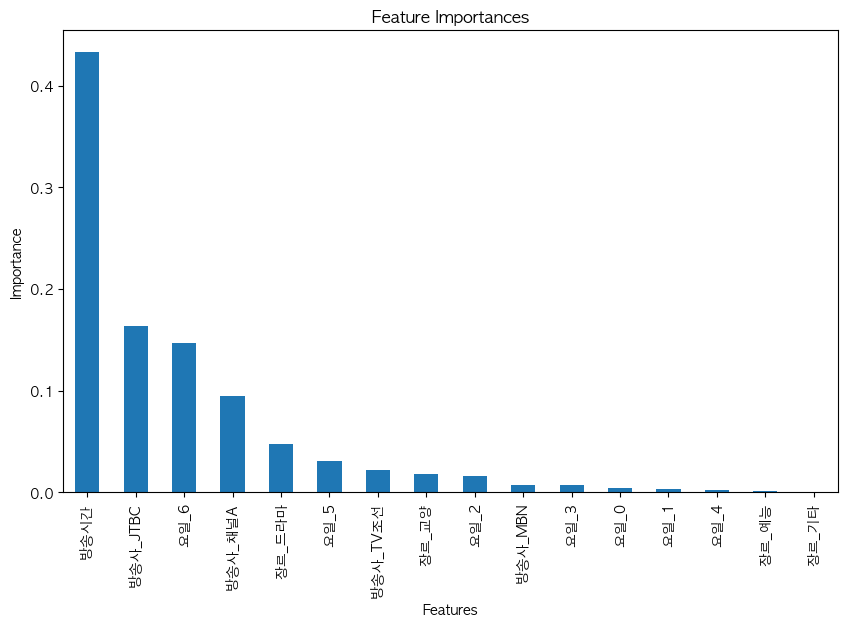

In [247]:
# 특성 중요도 추출
feature_importances = model.feature_importances_

# 특성 이름을 X_train에서 추출
feature_names = X.columns

# 특성 중요도를 Series로 변환하여 정렬
importances = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

# 막대그래프 시각화
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

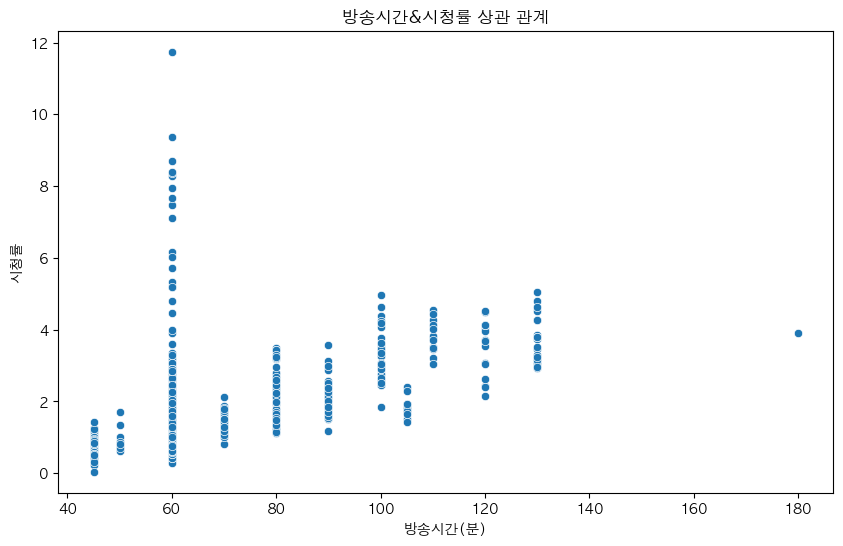

상관계수: 0.4944117328759948


In [228]:

# 시청률과 방송시간의 상관 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='방송시간', y='시청률', data=df)
plt.title('방송시간&시청률 상관 관계')
plt.xlabel('방송시간(분)')
plt.ylabel('시청률')
plt.show()

# Pearson 상관 계수
correlation = df['방송시간'].corr(df['시청률'])
print("상관계수:", correlation)

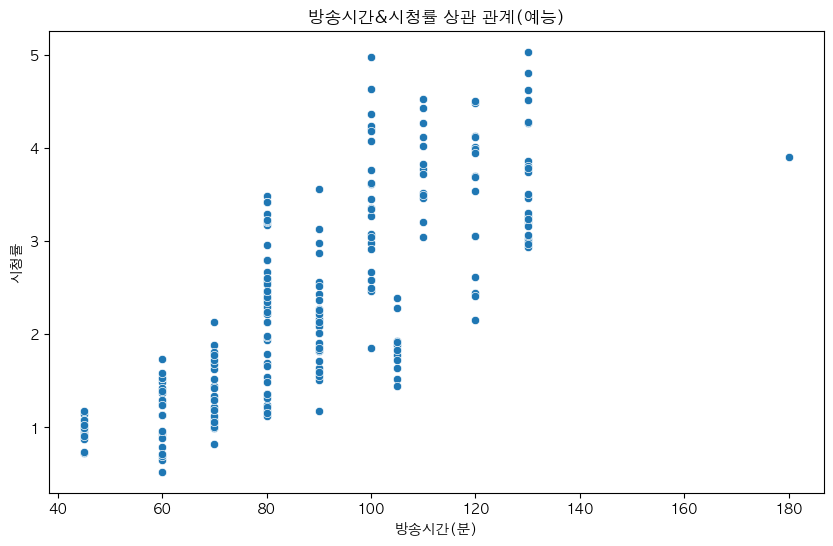

상관계수 0.7693485534939485


In [248]:
# 드라마 장르 제거
df_non_drama = df[df['장르'] != '드라마']

# 예능 장르만 필터링
df_variety = df_non_drama[df_non_drama['장르'] == '예능']

# 방송시간과 시청률의 산점도 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='방송시간', y='시청률', data=df_variety)
plt.title('방송시간&시청률 상관 관계(예능)')
plt.xlabel('방송시간(분)')
plt.ylabel('시청률')
plt.show()

# 예능 프로그램의 시청률과 방송시간 상관 계수 계산
correlation_variety = df_variety['방송시간'].corr(df_variety['시청률'])
print("상관계수", correlation_variety)

In [4]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for deap: filename=deap-1.4.1-cp312-cp312-macosx_12_0_arm64.whl size=104210 sha256=af506cbddddfbde5ad519a84370d9d1fc9819b7a849de3d3a2d8e0da56446d72
  Stored in directory: /Users/kimminsu/Library/Caches/pip/wheels/6c/1d/91/0a68add63bf57c3263b06b3462179d244fed0ff1dbb8d5eff0
Successfully built deap

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [11]:
import pandas as pd
from deap import base, creator, tools, algorithms
import random

# `y`를 시청률 데이터로 설정
y = df['시청률']

# 유전 알고리즘 설정과 실행
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(y)), len(y))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda ind: (sum(y.iloc[i] for i in ind),))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# 유전 알고리즘 실행
population = toolbox.population(n=50)
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=True)

# 최적 해 추출
best_ind = tools.selBest(population, 1)[0]
print('Best Schedule:', best_ind)
print('Best Fitness:', best_ind.fitness.values)


/Users/kimminsu/.pyenv/versions/3.12.4/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/kimminsu/.pyenv/versions/3.12.4/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	18    
2  	28    
3  	23    
4  	35    
5  	36    
6  	27    
7  	24    
8  	31    
9  	37    
10 	31    
11 	22    
12 	33    
13 	31    
14 	35    
15 	25    
16 	32    
17 	27    
18 	32    
19 	28    
20 	33    
21 	35    
22 	33    
23 	38    
24 	31    
25 	25    
26 	29    
27 	34    
28 	34    
29 	34    
30 	37    
31 	30    
32 	25    
33 	26    
34 	36    
35 	32    
36 	24    
37 	32    
38 	26    
39 	31    
40 	38    
Best Schedule: [433, 434, 213, 214, 222, 198, 200, 253, 195, 195, 191, 333, 316, 437, 457, 386, 348, 307, 181, 222, 136, 373, 111, 451, 389, 195, 198, 116, 36, 114, 248, 279, 458, 116, 288, 94, 439, 351, 386, 94, 197, 75, 1, 337, 99, 203, 166, 193, 186, 212, 136, 21, 461, 435, 205, 104, 408, 80, 202, 206, 193, 389, 159, 295, 251, 112, 226, 199, 64, 124, 177, 260, 382, 435, 409, 382, 434, 223, 204, 92, 453, 383, 22, 441, 155, 155, 9, 203, 195, 396, 1, 397, 2, 213, 193, 23, 262, 323, 7, 279, 261, 221, 186, 243, 191, 186, 121, 75, 154,

In [12]:
# Best Schedule의 프로그램 정보 출력
print("Optimal Program Schedule and Details:")
for index in best_ind:
    program_info = df.iloc[index]  # 원본 데이터에서 정보 추출
    print(f"Program ID {index}: {program_info['제목']}, 방송일: {program_info['방영일']}, 시청률: {program_info['시청률']}%")

Optimal Program Schedule and Details:
Program ID 433: 미스터 로또, 방송일: 2024-06-21 00:00:00, 시청률: 4.124%
Program ID 434: 미스터 로또, 방송일: 2024-06-14 00:00:00, 시청률: 4.429%
Program ID 213: 한번 더 체크타임, 방송일: 2024-07-15 00:00:00, 시청률: 0.748%
Program ID 214: 한번 더 체크타임, 방송일: 2024-07-08 00:00:00, 시청률: 0.74%
Program ID 222: 불타는 장미단 , 방송일: 2024-07-22 00:00:00, 시청률: 2.584%
Program ID 198: 낮과 밤이 다른 그녀, 방송일: 2024-07-13 00:00:00, 시청률: 7.473%
Program ID 200: 낮과 밤이 다른 그녀, 방송일: 2024-07-06 00:00:00, 시청률: 5.719%
Program ID 253: 명을 사수하는 사람들 , 방송일: 2024-07-03 00:00:00, 시청률: 0.726%
Program ID 195: 낮과 밤이 다른 그녀, 방송일: 2024-07-21 00:00:00, 시청률: 9.368%
Program ID 195: 낮과 밤이 다른 그녀, 방송일: 2024-07-21 00:00:00, 시청률: 9.368%
Program ID 191: 낮과 밤이 다른 그녀, 방송일: 2024-08-04 00:00:00, 시청률: 11.744%
Program ID 333: 한 번쯤 이혼할 결심, 방송일: 2024-09-01 00:00:00, 시청률: 2.153%
Program ID 316: 나쁜 기억 지우개, 방송일: 2024-08-10 00:00:00, 시청률: 1.543%
Program ID 437: 산따라 물따라 딴따라, 방송일: 2024-08-24 00:00:00, 시청률: 0.523%
Program ID 457: 식객 허영만의 백반기행, 방송일: 2024-08

In [13]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 48.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [15]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD, LpStatus

# 문제 정의: 최대 시청률
model = LpProblem(name="schedule-optimization", sense=LpMaximize)

# 변수: 각 프로그램이 특정 시간에 배치되는지 여부 (0 or 1)
x = {i: LpVariable(name=f"x_{i}", cat='Binary') for i in range(len(y))}

# 목적 함수: 시청률 최대화
model += lpSum([x[i] * y.iloc[i] for i in range(len(y))])

# 제약 조건 추가 예: 한 시간대에 하나의 프로그램만 허용
# model += (lpSum([x[i] for i in range(len(y))]) == 1, "One_program_per_slot")

# 문제 풀기
status = model.solve(PULP_CBC_CMD(msg=0))

# 결과 출력
print(f"Status: {model.status}, {LpStatus[model.status]}")  # LpStatus 딕셔너리를 사용하여 상태 코드를 문자열로 변환
print(f"Optimal Schedule: {[(i, x[i].value()) for i in range(len(y)) if x[i].value() == 1]}")

Status: 1, Optimal
Optimal Schedule: [(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 1.0), (25, 1.0), (26, 1.0), (27, 1.0), (28, 1.0), (29, 1.0), (30, 1.0), (31, 1.0), (32, 1.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0), (37, 1.0), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 1.0), (44, 1.0), (45, 1.0), (46, 1.0), (47, 1.0), (48, 1.0), (49, 1.0), (50, 1.0), (51, 1.0), (52, 1.0), (53, 1.0), (54, 1.0), (55, 1.0), (56, 1.0), (57, 1.0), (58, 1.0), (59, 1.0), (60, 1.0), (61, 1.0), (62, 1.0), (63, 1.0), (64, 1.0), (65, 1.0), (66, 1.0), (67, 1.0), (68, 1.0), (69, 1.0), (70, 1.0), (71, 1.0), (72, 1.0), (73, 1.0), (74, 1.0), (75, 1.0), (76, 1.0), (77, 1.0), (78, 1.0), (79, 1.0), (80, 1.0), (81, 1.0), (82, 1.0), (83, 1.0), (84, 1.0), (85, 1.0), (86, 1.0), (87, 1.0), (88,

In [16]:
# 예를 들어, 각 시간대별로 하나의 프로그램만 선택
for time_slot in unique_time_slots:
    model += (lpSum([x[i] for i in programs_at_time_slot[time_slot]]) == 1, f"One_program_at_{time_slot}")


NameError: name 'unique_time_slots' is not defined